In [12]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [13]:
# Load data and split word with its POS
def load_corpus(path):
    sentences = []
    with open(path, encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if line:
                sentences.append(line.split())
    return sentences

corpus = load_corpus("health_text_data.txt")
corpus_add = load_corpus("health_text_data - Copy.txt")

In [14]:
total_words = sum(len(sent) for sent in corpus)
print(total_words)

735


In [15]:
# Build Vocab & Tags
SEG_TAG = {"B": 0, "I": 1} # B=Beginning of a word, I=Inside a word

char_set = set()
pos_set = set()

for sent in corpus:
    for wp in sent:
        word, pos = wp.rsplit("/", 1)
        pos_set.add(pos) # to store all POS in corpus into pos_set
        for ch in word:
            char_set.add(ch) # to store all characters in corpus into char_set

CHAR2IDX = {c: i + 1 for i, c in enumerate(sorted(char_set))} # dict {char : index}
IDX2CHAR = {i: c for c, i in CHAR2IDX.items()}
POS2IDX = {p: i for i, p in enumerate(sorted(pos_set))} # dict {word : index}
IDX2POS = {i: p for p, i in POS2IDX.items()}

VOCAB_SIZE = len(CHAR2IDX) + 1

In [16]:
VOCAB_SIZE

78

In [17]:
# Encode Word -> Char sequence
def encode_sentence(sentence):
    chars, segs, pos_tags = [], [], []

    for wp in sentence:
        word, pos = wp.rsplit("/", 1)
        for i, ch in enumerate(word):
            chars.append(CHAR2IDX[ch])
            segs.append(SEG_TAG["B"] if i == 0 else SEG_TAG["I"])
            pos_tags.append(POS2IDX[pos])

    return chars, segs, pos_tags

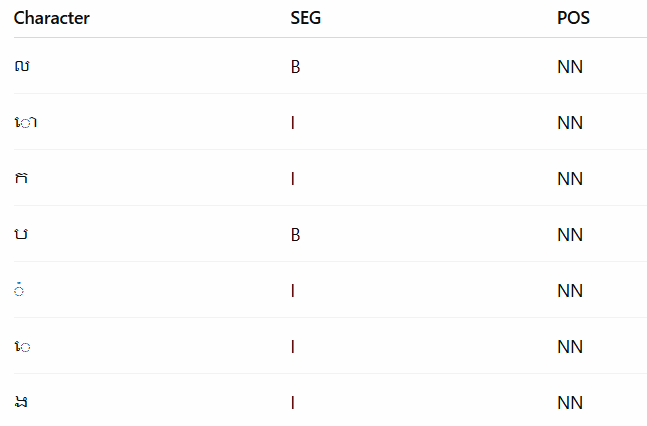

In [18]:
# Dataset
class KhmerPOSDataset(Dataset):
    def __init__(self, corpus, max_len=300):
        self.samples = []
        self.max_len = max_len

        for sent in corpus:
            c, s, p = encode_sentence(sent)
            if len(c) <= max_len:
                self.samples.append((c, s, p))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        c, s, p = self.samples[idx]
        pad = self.max_len - len(c)

        return (
            torch.tensor(c + [0] * pad),
            torch.tensor(s + [-100] * pad),
            torch.tensor(p + [-100] * pad),
        )

dataset = KhmerPOSDataset(corpus)
loader = DataLoader(dataset, batch_size=16, shuffle=True)

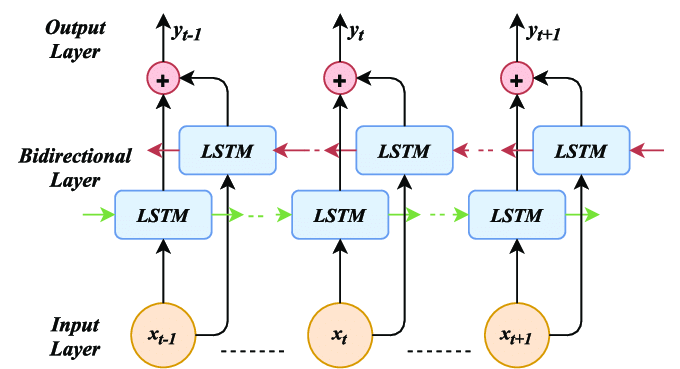

In [19]:
# Model
class BiLSTM_POS(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding(VOCAB_SIZE, 128, padding_idx=0) # convert integer word IDs into dense vectors of size 128
        self.lstm = nn.LSTM(128, 512, batch_first=True, bidirectional=True) # hidden: memory capacity, bidirectional = True (create 2 LSTMs, one read sentenc forward and one read it backward)
        self.seg_fc = nn.Linear(1024, 2) # where words end (seg)
        self.pos_fc = nn.Linear(1024, len(POS2IDX)) # what they mean (pos)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x) # multi-task learning: model learns features that are useful for both segment and tagging
        return self.seg_fc(x), self.pos_fc(x)

In [ ]:
# Training
device = "cuda" if torch.cuda.is_available() else "cpu"
model = BiLSTM_POS().to(device)

loss_fn = nn.CrossEntropyLoss(ignore_index=-100)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

EPOCHS = 20

for epoch in range(EPOCHS):
    total_loss = 0
    for chars, segs, pos in loader:
        chars, segs, pos = chars.to(device), segs.to(device), pos.to(device)

        optimizer.zero_grad()
        seg_out, pos_out = model(chars)

        loss = (
            loss_fn(seg_out.view(-1, 2), segs.view(-1)) +
            loss_fn(pos_out.view(-1, len(POS2IDX)), pos.view(-1))
        )

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}")

Epoch 1: Loss = 3.5281
Epoch 2: Loss = 2.7499
Epoch 3: Loss = 4.4429
Epoch 4: Loss = 2.9714
Epoch 5: Loss = 2.4765
Epoch 6: Loss = 2.3617
Epoch 7: Loss = 2.2739
Epoch 8: Loss = 2.1358
Epoch 9: Loss = 1.9844
Epoch 10: Loss = 1.8601
Epoch 11: Loss = 1.7281
Epoch 12: Loss = 1.5968
Epoch 13: Loss = 1.4672
Epoch 14: Loss = 1.2901
Epoch 15: Loss = 1.1705
Epoch 16: Loss = 0.9890
Epoch 17: Loss = 0.8543
Epoch 18: Loss = 0.7048
Epoch 19: Loss = 0.5778
Epoch 20: Loss = 0.4607


In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BiLSTM_POS().to(device)

loss_fn = nn.CrossEntropyLoss(ignore_index=-100)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

EPOCHS = 20

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for chars, segs, pos in loader:
        chars, segs, pos = chars.to(device), segs.to(device), pos.to(device)

        optimizer.zero_grad()
        seg_out, pos_out = model(chars)

        loss = (
            loss_fn(seg_out.reshape(-1, 2), segs.reshape(-1)) +
            loss_fn(pos_out.reshape(-1, len(POS2IDX)), pos.reshape(-1))
        )

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}: Loss = {total_loss / len(loader):.4f}")


Epoch 1: Loss = 3.5325
Epoch 2: Loss = 2.7096
Epoch 3: Loss = 5.4767
Epoch 4: Loss = 3.1549
Epoch 5: Loss = 2.4695
Epoch 6: Loss = 2.4165
Epoch 7: Loss = 2.3657
Epoch 8: Loss = 2.2671
Epoch 9: Loss = 2.1339
Epoch 10: Loss = 2.0036
Epoch 11: Loss = 1.8798
Epoch 12: Loss = 1.7532
Epoch 13: Loss = 1.6391
Epoch 14: Loss = 1.5273
Epoch 15: Loss = 1.3766
Epoch 16: Loss = 1.2172
Epoch 17: Loss = 1.0906
Epoch 18: Loss = 0.9236
Epoch 19: Loss = 0.7815
Epoch 20: Loss = 0.6424


In [23]:
# Prediction function
def predict(text):
    text = text.replace(" ", "").strip()
    chars = torch.tensor([CHAR2IDX.get(c, 0) for c in text]).unsqueeze(0).to(device)

    with torch.no_grad():
        seg_out, pos_out = model(chars)

    seg = seg_out.argmax(-1)[0]
    pos = pos_out.argmax(-1)[0]

    results = []
    current_word = ""
    current_pos = None

    for i, ch in enumerate(text):
        if seg[i] == 0:  # B
            if current_word:
                results.append((current_word, current_pos))
            current_word = ch
            current_pos = IDX2POS[pos[i].item()]
        else:
            current_word += ch

    if current_word:
        results.append((current_word, current_pos))

    return results

In [24]:
# Test
test_sentence = "លាងដៃឱ្យបានស្អាតជាមួយអាល់កុល"
print(predict(test_sentence))

[('លាង', None), ('ដៃ', 'VB'), ('ឱ្យ', 'VB'), ('បាន', 'VB'), ('ស្អាត', 'NN'), ('ជាមួយ', 'VB'), ('អាល់', 'JJ'), ('កុល', 'NN')]


Add extra-data

In [25]:
# Build Vocab & Tags
char_set_add = set()
pos_set_add = set()

for sent in corpus_add:
    for wp in sent:
        word, pos = wp.rsplit("/", 1)
        pos_set_add.add(pos)
        for ch in word:
            char_set_add.add(ch)

CHAR2IDX = {c: i + 1 for i, c in enumerate(sorted(char_set_add))}
IDX2CHAR = {i: c for c, i in CHAR2IDX.items()}
POS2IDX = {p: i for i, p in enumerate(sorted(pos_set_add))}
IDX2POS = {i: p for p, i in POS2IDX.items()}

VOCAB_SIZE = len(CHAR2IDX) + 1

In [26]:
VOCAB_SIZE

87